In [50]:
import json
import pandas as pd
import requests
from requests.exceptions import HTTPError
import spotipy
from spotipy.oauth2 import SpotifyOAuth


scope = "user-top-read"

spotify = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, redirect_uri="http://localhost:9111/"))


def pager(response):
    #print(json.dumps(response['items'][0]['artists'], indent=2))
    #print(response['total'])
    if 'items' in response:
        yield from (
            item for item in response['items'] if item
        )
    if 'next' in response and response['next']:
        yield from pager(spotify.next(response))


def top_tracks():
    for track in pager(spotify.current_user_top_tracks(time_range="long_term")):
        yield track


def analysis(track_ids):
    for track_id in track_ids:
        yield {
            "id": track_id,
            **spotify.audio_analysis(track_id)["track"]
        }

def extract_genres(artist_list):
    for artist in spotify.artists([artist["id"] for artist in artist_list])["artists"]:
        if "genres" in artist:
            for genre in artist["genres"]:
                yield genre


df = pd.DataFrame(top_tracks())
#df['album_uri'] = df['album'].apply(lambda album: album['href'])
df = df[['id', 'name', 'artists', 'album', 'popularity', 'explicit']]
df['genres'] = df['artists'].apply(lambda x: set(extract_genres(x)))

df = df.merge(pd.DataFrame(spotify.audio_features(df['id'])), on=['id'])
df.drop(['key', 'loudness', 'mode', 'time_signature', 'tempo'], inplace=True, axis=1)

df = df.merge(pd.DataFrame(analysis(df['id'])), on=['id'])
df

,id,name,artists,album,popularity,explicit,genres,danceability,energy,speechiness,...,mode,mode_confidence,codestring,code_version,echoprintstring,echoprint_version,synchstring,synch_version,rhythmstring,rhythm_version
0,5Tp6dPrDC8xGtc4YCYUAWo,Pumping Iron,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'COMPILATION', 'artists': [{'ex...",35,False,{},0.459,0.940,0.0351,...,1,0.606,eJxVnIm147gORFNxCCIlbvknNvcWZPebPn9p0VpIECgUFv...,3.15,eJzdnQma5MiNpa9E0vbj2Hr_I8z_wFQwMz7RfGqiSuoeqR...,4.12,eJxVWImVJDsIS8UhmMNX_ol9JFG989_uzHSXLxBC4HKfa4...,1.0,eJyVXQmW7Kiu3Eouwcyw_419FCEJ4cx6ff85t7qynDYGDa...,1.0
1,2w48JV8QDWSgBNLUjYKZP7,Stamina,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'ALBUM', 'artists': [{'external...",30,False,{synthwave},0.464,0.862,0.0459,...,1,0.612,eJxdmwmW5bqtBLdSS5A4c_8b-xEJVb32b_vYJV4NJIghkQ...,3.15,eJzdvQuyJLmRZLslxx9YDr77X8I7alGsW6zXjiuUmBJOD7...,4.12,eJxVmguW3DoIRLfSS7DQf_8be6Zu4ck7SSaebllGfIoCHP...,1.0,eJyNXAmS4zgM-0qeYN3S_z-2AkDqcDIzW7W9053YskTxAE...,1.0
2,5Zn4r21QBZwrcStFv57jhY,Hearts on Fire,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'ALBUM', 'artists': [{'external...",25,False,"{synthwave, nightrun, popwave}",0.655,0.678,0.0349,...,1,0.398,eJxdmwkW3LauRLfSSxBJcdr_xv69BdnOf0mOY7EligSBQm...,3.15,eJzVnQmW7TaSZLdEYsZyMO5_CX3Nn_JTipNElDr0W9VZlZ...,4.12,eJxdmYl15LoORFNRCCK4Kv_EPuoW2J73z3jaapEEsRRWR7...,1.0,eJx9XAmy46gSvIqPIHa4_8U-uRRCryd-RM_Yz5YQUFtWVu...,1.0
3,3Qaq3lUUawG3MEWvRcNBcx,Juliette,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'SINGLE', 'artists': [{'externa...",45,False,"{nightrun, popwave}",0.560,0.743,0.0272,...,1,0.189,eJxVm1mWJCsORLcSS8CZHPa_sb7XFJGvuj7ylBM-gJBMpo...,3.15,eJzNvQmW5TaStLslgpiXg3H_S3if-a1OpuJvIl6eqDxqqe...,4.12,eJxNmImR7DgMQ1NRCCZ155_YEg_q-Vs11e2xZYoHCEKd-c...,1.0,eJxlXIeR3DAMbEUlMIf-GzM3gNK9Z-zx--8kMQCLxQJUzq...,1.0
4,2rl0WAMR1CMtn0svwCXOwK,Nock Em,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'SINGLE', 'artists': [{'externa...",52,False,"{speedrun, chiptune}",0.602,0.892,0.2530,...,1,0.678,eJxVmwlyJDkOBL9ST-B9_P9j4x4sTUu2trtNViaTBIFA4N...,3.15,eJzlnQmuJDfSpK8U3MnjcL3_EeYzz4Ze95sJ5i_UCD3ASI...,4.12,eJxlWgluGzEM_IqesKLu_3-s4hxygKJB6thaHTxmhpQjvv...,1.0,eJyVXAeW3DoOvEofgTnc_2LLCqDUY3vt_57H061AgSRCoQ...,1.0
5,2knr7ikPt4l7bk92qS4ZXW,Euphoria,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'ALBUM', 'artists': [{'external...",70,False,"{europop, swedish pop}",0.518,0.679,0.0355,...,0,0.191,eJxVmgmuHDsOBK9SR9C-3P9iE5Fqj_1hwHhiV0kURSaTVN...,3.15,eJy1vQuO9brRZDsliU9xOCJFzn8Idy1V37bxo8WNxoeGj8...,4.12,eJxVWAuW7CoI3IpLEPxm_xt79cGe-87p6ZhEEYqipCezr9...,1.0,eJxlnAeS7DYQQ6-iIzCH-1_MBF5Tmv2u8q_d2ZEohg4Auu...,1.0
6,6pFqLrkXs49znnUVh2Ge31,Power Fighter 3000,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'ALBUM', 'artists': [{'external...",30,False,"{synthwave, spacewave, darksynth}",0.543,0.951,0.1350,...,1,0.362,eJxVm1mi3DgOBK9SR-C-3P9iE5GU256Pdj-xtFAkkEgkoF...,3.15,eJy1nQmSJDuOZK9k3MnjcL3_EeYp_E96_RQxhtTEVM80qi...,4.12,eJxdWQm25DgIu4qPYDDe7n-xMZJI_Z43md-pxAsGIZa499...,1.0,eJx9XAmS3LqOvEodgaS43v9iw1xAUe03P8J2V6skLiCQSC...,1.0
7,1Ht4NJdY8adMsW540P5vG0,Come With Me - Radio Mix,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'SINGLE', 'artists': [{'externa...",65,False,"{progressive house, deep house, house, swiss p...",0.677,0.758,0.0270,...,0,0.711,eJxdmouN4zAMRFtxCaL-6r-xezOUk-zhgMPKsS3xNxySjl...,3.15,eJztvQuS7riNrTsliW8Oh8_5D-F8C6re2pXHPzOq03XLvn...,4.12,eJxNmAl25ToOQ7fiJVikBnv_Gyvign6p09X5iS1LHAFQEf...,1.0,eJyVWwuW5CAOu0qOEP7m_hdbSzKEVFXP7r7X87or5RgDti...,1.0
8,4IoCXKpR6xIZWAIU1o4Utp,Bend & Break,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'SINGLE', 'artists': [{'externa...",39,False,"{synthwave, nightrun, popwave}",0.519,0.637,0.0309,...,1,0.494,eJxdnAmSJDcOBL9ST-B9_P9jcg9Wz_RozaRtsjKZPHBEAK...,3.15,eJzVnQuaJLmtnbcUDL6Xw-f-l-D_IEadPWUFy3PLbcn-ZF...,4.12,eJxNWAm2IzkIu4qPUCze7n-xRhLO7zc9P4nLxixCQLl_8x...,1.0,eJx1XQmSZKkO

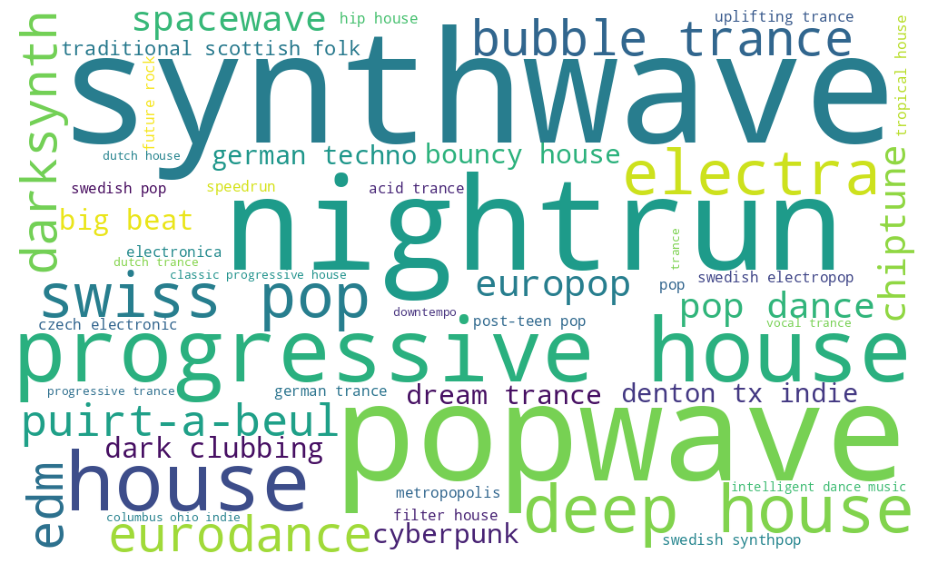

In [64]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter



genres = Counter()
for g in df['genres']:
    genres.update(g)

wordcloud = WordCloud(width=1000, height=600, max_words=50,
            background_color='white', contour_width=3, contour_color='steelblue',
            min_font_size=10).generate_from_frequencies(genres)

plt.figure(figsize=(10,6), facecolor='white') 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad=2)
plt.show()